In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.widgets import Slider, Button
import scipy
import scipy.optimize
import scipy.io
from scipy.interpolate import interp1d
import nmrglue as ng
import pandas as pd
#also requires openpyxl

from cops_analysis import cops_analyze

In [2]:
%%time 
import os
os.chdir('/home/nmrbox/hwang/Documents/COPS_dev/')
a = cops_analyze(['../no_pyruvate/GB1_BCG1.ucsf','../no_pyruvate/GB1_BCG3.ucsf','../no_pyruvate/GB1_BCG4.ucsf','../no_pyruvate/GB1_BCG5.ucsf','../no_pyruvate/GB1_BCG6.ucsf',], mode='HCA',pyruvate_on=False)


CPU times: user 58.1 ms, sys: 116 ms, total: 174 ms
Wall time: 1.42 s


In [4]:
tb=pd.read_fwf('../no_pyruvate/GB1_BCG1.list', infer_nrows=300)
tb = tb.rename(columns={'w1':'CA','w2':'HN'})

#realign spectra
tb = tb.set_index(tb['Assignment'])
tb = tb.drop(columns='Assignment')

shifts_array = tb.to_numpy(dtype=np.float32)
tb

,CA,HN
Assignment,,
T1Ca-HN,52.978,8.284
T1Ca-Y2HN,52.978,9.048
Y2Ca-HN,54.261,9.048
Y2Ca-K3HN,54.261,9.048
K3Ca-HN,52.176,9.047
...,...,...
V53Ca-HN,55.099,8.179
V53Ca-T54HN,55.089,8.303
T54Ca-HN,57.846,8.304


In [5]:
a.CalcCB(shifts_array[7], simple_output=False)

484.60645795667847


(array([37.84390836,  0.999     , 39.03317259,  3.99080895, 56.51383941,
         9.52233465]),
 0.0020635300739004912)

In [17]:
%%time
CBs = []
credence = []

for i in range(len(shifts_array)):
    try: 
        result = a.CalcCB(shifts_array[i], simple_output=False, sw = 70)
    except:
        result = ([0,0,0,0,0],[1])
    CBs = np.append(CBs, result[0][2])
    credence = np.append(credence, result[1])
tb['CB'] = CBs
tb['1/covariance'] = 1/credence

279.4439010660288
234.67771233437566
297.43481388165947
297.43481388165947
214.71301575807271
233.75562806697366
158.99329636342878
164.4437583603251
255.52753366941832
257.5463366053982
100.56157642406467
107.50478581275965
232.3491939332302
291.06824281393347
1632.2426783426292
1754.2528643092885
169.27449713421214
204.80484981394878
34.76292962704394
46.85605510982051
188.536719877603
182.0308130161383
135.41533490619796
148.425167314176
1605.1783445989172
1614.5593277389225
304.0075073756605
217.1131264494755
29.23358374759236
44.91088028376056
33.088631433224016
40.85996489949106
34.079544437611055
47.479082438374505
239.52739198994112
222.44317745402685
141.50064400391472
181.7516852135796
165.89036955435208
181.10713777533198
60.81817374505444
80.79297965786219
110.39187503375081
431.3495987659529
109.631254374891
445.03136808984925
21.2582206109019
33.210442691158406
99.71538170351386
376.43467250840257
246.58742854454601
1128.3056744482178
480.3356923214464
249.68677529616508


In [18]:
tb

,CA,HN,CB,1/covariance
Assignment,,,,
T1Ca-HN,52.978,8.284,27.404211,279.443901
T1Ca-Y2HN,52.978,9.048,27.264897,234.677712
Y2Ca-HN,54.261,9.048,39.802154,297.434814
Y2Ca-K3HN,54.261,9.048,39.802154,297.434814
K3Ca-HN,52.176,9.047,32.316757,214.713016
...,...,...,...,...
V53Ca-HN,55.099,8.179,28.897081,156.423676
V53Ca-T54HN,55.089,8.303,28.890304,160.986699
T54Ca-HN,57.846,8.304,45.122087,33.463465


In [6]:
tb_truth = pd.read_excel('GB1_ground_truth_hw.xlsx')

In [7]:
tb['CB_scott'] = tb_truth['CB_scott'].to_numpy()
tb.to_excel('CB_fit_results_nopyruvate.xlsx')

## DEV

In [69]:
def extract1D(data_pt_ppm, spectrum, uc, sw=100.1, C_offset = 0, normalize=False):

    #convert data_pt_ppm to index

    if a.mode=='HNCA':

        idx = np.array([uc[0](data_pt_ppm[0], "ppm"), uc[1](data_pt_ppm[1]+C_offset, "ppm"), uc[2](data_pt_ppm[2], "ppm")])
        #calculate indices for trace boundary, based on tw. 
        hz_bounds = a.hz_to_idx(uc[1], sw)
        hz_vals = np.linspace(-hz_bounds, hz_bounds, num=2*hz_bounds+1)*sw/hz_bounds

        #1D slice through peak center, weight-added by tensor product to 1D 13C slices nearby (in the HN, N dimensions)
        weights = np.array([[0.6, 0.8, 0.9, 1, 0.9, 0.8, 0.6]]) #weights vector to compute weighted sum
        slices = spectrum[idx[0]-3:idx[0]+4, idx[1]-hz_bounds:idx[1]+hz_bounds+1,idx[2]-3:idx[2]+4]
        trace = np.tensordot(slices,weights.T@weights, axes=([0,2],[0,1]))
        trace = np.array(trace)
    elif a.mode=='HCA':
        idx = np.array([uc[i](data_pt_ppm[i], "ppm") for i in range(len(uc))])
        #calculate indices for trace boundary, based on tw. 
        hz_bounds = a.hz_to_idx(uc[0], sw)
        hz_vals = np.linspace(-hz_bounds, hz_bounds, num=2*hz_bounds+1)*sw/hz_bounds
        #1D slice through peak center, weight-added by tensor product to 1D 13C slices nearby (in the HN, N dimensions)
        weights = np.array([[0.4,0.8,1,0.8,0.4]]) #weights vector to compute weighted sum
        slices = spectrum[idx[0]-hz_bounds:idx[0]+hz_bounds+1, idx[1]-2:idx[1]+3]
        trace = slices@weights.T
        trace = np.array(trace)

    normalizer=np.sum(trace)

    if normalize:
        #normalize by peak volume
        trace=trace/normalizer*(2*hz_bounds+1)
    return hz_vals, trace

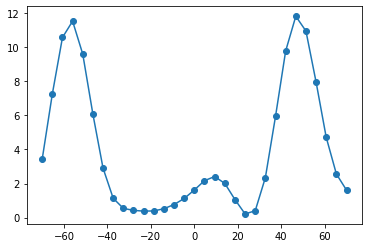

In [16]:
diagnose = shifts_array[3] #18 for K27, #-4 for K49
#diagnose = [51.6, 8.21]
hz, nocop_trace= a.extract1D(diagnose, a.cop_dats[0], a.cop_unit_convs[0], sw=70, normalize=True)
plt.plot(hz, nocop_trace, '-o')

In [11]:
data = shifts_array[1]
params,_ = a.CalcCB(data, simple_output=False)
print([(1+a.dec_interpolation[i](params[2]))/2 for i in range(5)])
print(params)
print(params[2])

[0.99922562202695, 0.6164240778049888, 0.9972319609911423, 0.9895554077368358, 0.9993142517251683]
[39.99999996  1.         42.9851771  24.56666616 34.80521586  8.483489  ]
42.985177100820835


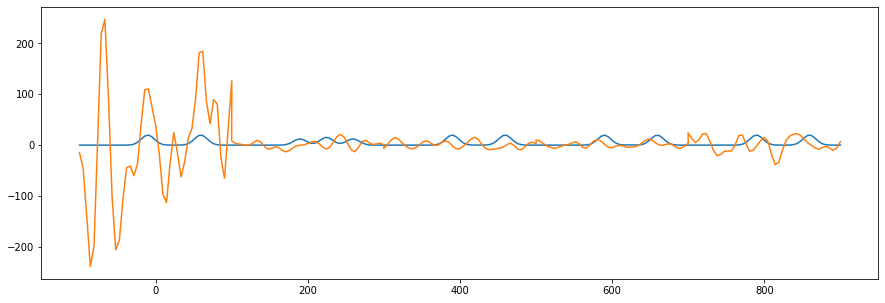

In [12]:
hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)[1] for i in range(5)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(5)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, a.lineshape_Cb(hz, *params), hz_long, cop_1Ds)